In [380]:
import numpy as np
import control as ctrl
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [381]:
Ts = 0.01

A = np.array([[1]])
B = np.array([[1]])
C = np.array([[1]])
D = np.array([0])

sys_c = ctrl.ss(A, B, C, D)
sys_d = ctrl.c2d(sys_c, Ts, method='zoh')
Ad = sys_d.A
Bd = sys_d.B
Cd = sys_d.C
Dd = sys_d.D

print("Discrete-time system matrices:")
print("Ad:", Ad)
print("Bd:", Bd)
print("Cd:", Cd)
print("Dd:", Dd)

Discrete-time system matrices:
Ad: [[1.01005017]]
Bd: [[0.01005017]]
Cd: [[1.]]
Dd: [[0.]]


## *Resumen de simulaciones ejecutadas*

En las simulaciones se consideran los siguientes hiperparámetros:

- Tiempo de muestreo o de *step* de integración: $T_s = 0.01 \,[s]$
- Misma condición inicial para estados y estados virtuales ($x(0) = z(0)$): **True / False**
- Uso de un *timer* de un segundo para llevar a $\dot{\vartheta} = 0$: **True / False**
- Método de integración: **RK4 propio**, **solve_ivp RK4**, **Euler**

Además, considerar la **siguiente dinámica de consenso**: 
$$\dot{z}_i = g(z_i,v_i)$$
$$g(z_i,v_i) = v_i $$
$$v_i= -\sum_{j\neq i}\text{sign}(z_i-z_j)|z_i-z_j|^{0.5}$$

---

### Tabla de configuraciones

| Nº Simulación | $x(0)=z(0)$ | Timer 1s $\dot{\vartheta}=0$ | Método de integración | Observaciones |
|---------------|-------------|-----------------------------|------------------------|---------------|
| 1             | True        | True                        | RK4 propio             |     $\vartheta$ converge $\forall \ i \in \{1, \cdots, N\}$, todos convergen a un mismo valor        |
| 2             | True        | True                        | solve_ivp RK4          |     $\vartheta$ no converge $\forall \ i \in \{1, \cdots, N\}$         |
| 3             | True        | True                        | Euler                  |               |
| 4             | True        | False                       | RK4 propio             |     $\vartheta$ converge $\forall \ i \in \{1, \cdots, N\}$, todos convergen a valores distintos: las curvas se separan          |
| 5             | True        | False                       | solve_ivp RK4          |     $\vartheta$ converge $\forall \ i \in \{1, \cdots, N\}$, todos convergen a valores distintos: las curvas se separan           |
| 6             | True        | False                       | Euler                  |               |
| 7             | False       | True                        | RK4 propio             |     $\vartheta$ converge para $i \in \{5,6,9\}$, estos convergen a valores distintos pero su evolución da origen aun misma recta       |
| 8             | False       | True                        | solve_ivp RK4          |     $\vartheta$ no converge $\forall \ i \in \{1, \cdots, N\}$           |
| 9             | False       | True                        | Euler                  |               |
| 10            | False       | False                       | RK4 propio             |     $\vartheta$ converge para $i \in \{5,6,7,9\}$, estos convergen a valores distintos pero su evolución da origen aun misma recta        |
| 11            | False       | False                       | solve_ivp RK4          |     $\vartheta$ no converge $\forall \ i \in \{1, \cdots, N\}$         |
| 12            | False       | False                       | Euler                  |               |

---

> **Nota:** La columna *Observaciones* puede completarse con métricas de desempeño, errores, tiempo de ejecución o cualquier hallazgo relevante de cada simulación.


##### *Simulation parameters*

In [382]:
RUN_LOOP_SOLVE_IVP = False  # Set to True to run the solve_ivp simulation loop

# Simulation type: int32 transmission between agents or float
use_same_init_conditions = True
scale_factor = 1000

# Simulation parameters: 
dt       = 0.01                         # sampling time
sim_time = 15.0                         # total simulation time 
time     = np.arange(0, sim_time, dt)   # time vector
n_points = len(time)                    # number of time points
n_agents = 9                            # number of agents

# Adaptive gain parameters: 
eta               = 0.5                     # adaptation gain
add_disturbance   = True                    # add disturbance to system
error_timer       = True                    # enable timer to stop gain evolution
small_error_timer = np.zeros(n_agents)      # timer to stop gain evolution
freeze_threshold  = 0.01                    # error-threshold to freeze gain evolution ("δ" or "ε" in paper)
freeze_time       = 1.0                     # time to freeze gain evolution after threshold is reached   
freeze_steps      = int(freeze_time / dt)   # time steps to freeze gain evolution after threshold is reached

# Distrbance: bounded unknown input 
nu = 0.5 * (np.random.rand(n_agents, n_points) - 0.5)  # uniformly distributed between -0.25 and 0.25

# Sim-params dictionary: 
params = {
    "dt": dt,
    "n_points": n_points,
    "delta": freeze_threshold,
    "error_timer": error_timer,
    "small_error_timer": small_error_timer,
    "freeze_steps": freeze_steps,
    "add_disturbance": add_disturbance,
}

# Plotting parameters & function: 
NUM_SIM = 1
SAVE_FIGS = False
FIG_FORMAT = 'pdf'  # 'png', 'pdf', 'svg', etc.

def plot_simulation_grid(t, x, z, vartheta, mv, n_agents, save_path=None, epsilon=freeze_threshold):
    """
    Plot x, z, vartheta, and u in a 2x2 grid.
    
    Parameters:
    - t: time vector
    - x, z, vartheta, mv: 2D arrays of shape (n_agents, n_points)
    - n_agents: number of agents
    - save_path: path to save figure (optional)
    """
    # Trim last time step (if necessary)
    t = t[:-1]
    x = x[:,:-1]
    z = z[:,:-1]
    sigma = x - z
    vartheta = vartheta[:,:-1]
    mv = mv[:,:-1]

    fig, axs = plt.subplots(2, 2, figsize=(14, 8))
    
    # --- Top-left: x_i ---
    for i in range(n_agents):
        axs[0,0].plot(t, x[i,:], label=f'$x_{i+1}$')
    axs[0,0].plot(t, z[0,:], 'k--', label='$z_{1}$ (ref.)')  # Reference trajectory
    axs[0,0].set_title('States $x_i$')
    axs[0,0].set_xlabel('Time [s]')
    axs[0,0].set_ylabel('$x[k]$')
    axs[0,0].legend(ncol=3)
    axs[0,0].grid(True)
    
    # --- Top-right: sigma_i ---
    for i in range(n_agents):
        axs[0,1].plot(t, sigma[i,:], label=f'$\\sigma_{i+1}$')
    axs[0,1].axhline(epsilon, color='k', linestyle='--', label='$\\pm \\delta$')
    axs[0,1].axhline(-epsilon, color='k', linestyle='--')
    axs[0,1].set_title('Error term $\\sigma_i$')
    axs[0,1].set_xlabel('Time [s]')
    axs[0,1].set_ylabel('$\\sigma[k]$')
    axs[0,1].legend(ncol=3)
    axs[0,1].grid(True)
    
    # --- Bottom-left: vartheta_i ---
    for i in range(n_agents):
        axs[1,0].plot(t, vartheta[i,:], label=f'$\\vartheta_{i+1}$')
    axs[1,0].set_title('Adaptive gains $\\vartheta_i$')
    axs[1,0].set_xlabel('Time [s]')
    axs[1,0].set_ylabel('$\\vartheta[k]$')
    axs[1,0].legend(ncol=3)
    axs[1,0].grid(True)
    
    # --- Bottom-right: control u (example: first agent) ---
    axs[1,1].plot(t, mv[0,:], label='$u_1$')
    axs[1,1].set_title('Control input $u_1$')
    axs[1,1].set_xlabel('Time [s]')
    axs[1,1].set_ylabel('$u[k]$')
    axs[1,1].legend()
    axs[1,1].grid(True)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        print(f"Figure saved to {save_path}")
    plt.show()

##### *Nodes and graph definirtion*
- $N=9$ agents 
- $N$-node ring directed: 
 
`... → v9 → v1 → v2 → v3 → v4 → v5 → v6 → v7 → v8 → v9 → v1 → ...`

- ***For now*, use the same initial condition for both state $x$ and virtual state $z$**

In [383]:
np.random.seed(42)

# Initial conditions: for states "x" and virtual states "z"

state1_x0 = np.random.uniform(-2.0, 2.0)
state2_x0 = np.random.uniform(-2.0, 2.0)
state3_x0 = np.random.uniform(-2.0, 2.0)
state4_x0 = np.random.uniform(-2.0, 2.0)
state5_x0 = np.random.uniform(-2.0, 2.0)
state6_x0 = np.random.uniform(-2.0, 2.0)
state7_x0 = np.random.uniform(-2.0, 2.0)
state8_x0 = np.random.uniform(-2.0, 2.0)
state9_x0 = np.random.uniform(-2.0, 2.0)

state1_x0_int32 = np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)
state2_x0_int32 = np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)
state3_x0_int32 = np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)
state4_x0_int32 = np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)
state5_x0_int32 = np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)
state6_x0_int32 = np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)
state7_x0_int32 = np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)
state8_x0_int32 = np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)
state9_x0_int32 = np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)

if use_same_init_conditions: 
    state1_z0 = np.copy(state1_x0)
    state2_z0 = np.copy(state2_x0)
    state3_z0 = np.copy(state3_x0)
    state4_z0 = np.copy(state4_x0)   
    state5_z0 = np.copy(state5_x0)
    state6_z0 = np.copy(state6_x0)
    state7_z0 = np.copy(state7_x0)
    state8_z0 = np.copy(state8_x0)
    state9_z0 = np.copy(state9_x0)

    state1_z0_int32 = np.copy(state1_x0_int32)
    state2_z0_int32 = np.copy(state2_x0_int32)
    state3_z0_int32 = np.copy(state3_x0_int32)
    state4_z0_int32 = np.copy(state4_x0_int32)
    state5_z0_int32 = np.copy(state5_x0_int32)
    state6_z0_int32 = np.copy(state6_x0_int32)
    state7_z0_int32 = np.copy(state7_x0_int32)
    state8_z0_int32 = np.copy(state8_x0_int32)
    state9_z0_int32 = np.copy(state9_x0_int32)
    

else:
    state1_z0 = np.random.uniform(-2.0, 2.0)
    state2_z0 = np.random.uniform(-2.0, 2.0)
    state3_z0 = np.random.uniform(-2.0, 2.0)
    state4_z0 = np.random.uniform(-2.0, 2.0)
    state5_z0 = np.random.uniform(-2.0, 2.0)
    state6_z0 = np.random.uniform(-2.0, 2.0)
    state7_z0 = np.random.uniform(-2.0, 2.0)
    state8_z0 = np.random.uniform(-2.0, 2.0)
    state9_z0 = np.random.uniform(-2.0, 2.0)

    state1_z0_int32 = np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)
    state2_z0_int32 = np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)
    state3_z0_int32 = np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)
    state4_z0_int32 = np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)
    state5_z0_int32 = np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)
    state6_z0_int32 = np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)
    state7_z0_int32 = np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)
    state8_z0_int32 = np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)
    state9_z0_int32 = np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)

`... → v9 (Bridge) → v1 (BLE) → v4 (BLE) → v7 (BLE) → v3 (Bridge) → v8 (WiFi) → v6 (WiFi) → v2 (WiFi) → v5 (Bridge) → v9 (Bridge) → v1 (BLE) → ...`

In [384]:
NODES = {
    0: {'x0': state1_x0, 'z0': state1_z0, 'x0_int32': state1_x0_int32, 'z0_int32': state1_z0_int32, 'neighbors': [3], 'type': 'BLE'},
    1: {'x0': state2_x0, 'z0': state2_z0, 'x0_int32': state2_x0_int32, 'z0_int32': state2_z0_int32, 'neighbors': [4], 'type': 'WiFi'},
    2: {'x0': state3_x0, 'z0': state3_z0, 'x0_int32': state3_x0_int32, 'z0_int32': state3_z0_int32, 'neighbors': [7], 'type': 'Bridge'},
    3: {'x0': state4_x0, 'z0': state4_z0, 'x0_int32': state4_x0_int32, 'z0_int32': state4_z0_int32, 'neighbors': [6], 'type': 'BLE'},
    4: {'x0': state5_x0, 'z0': state5_z0, 'x0_int32': state5_x0_int32, 'z0_int32': state5_z0_int32, 'neighbors': [8], 'type': 'WiFi'},
    5: {'x0': state6_x0, 'z0': state6_z0, 'x0_int32': state6_x0_int32, 'z0_int32': state6_z0_int32, 'neighbors': [1], 'type': 'Bridge'},
    6: {'x0': state7_x0, 'z0': state7_z0, 'x0_int32': state7_x0_int32, 'z0_int32': state7_z0_int32, 'neighbors': [2], 'type': 'BLE'},
    7: {'x0': state8_x0, 'z0': state8_z0, 'x0_int32': state8_x0_int32, 'z0_int32': state8_z0_int32, 'neighbors': [5], 'type': 'WiFi'},
    8: {'x0': state9_x0, 'z0': state9_z0, 'x0_int32': state9_x0_int32, 'z0_int32': state9_z0_int32, 'neighbors': [0], 'type': 'Bridge'},
}

# Consensus laws (Dynamics): --------------------------------------------------

# Graph: Laplacian matrix for the directed ring 9-node network
L = np.zeros((n_agents, n_agents))
for i in range(n_agents):
    L[i, i] = 1
    L[i, (i + 1) % n_agents] = -1
    L[i, (i - 1) % n_agents] = -1
# To use:  v = -L @ z[:, k]grad

# Virtual state dynamics (z): z_i_dot = g(z_i, v_i) = v_i
def v_i(i, z, neighbors):
    diffs = z[i] - z[neighbors]         
    return -np.sum(np.sign(diffs) * np.sqrt(np.abs(diffs)))

def g_i(i, z, neighbors, avg=False):
    if avg:
        if not neighbors:
            return 0.0
        return sum(z[j] - z[i] for j in neighbors)
    else:
        vi = v_i(i, z, neighbors)
        return vi
    
# Initial conditions for states and virtual states: ---------------------------
init_conditions = {
    "x": np.array([NODES[i]['x0'] for i in range(n_agents)]),
    "z": np.array([NODES[i]['z0'] for i in range(n_agents)]),
    "vtheta": np.zeros(n_agents)  # Initial adaptive gains
}

### *State dynamics*

In [385]:
def dynamics(t, y, nodes, n_agents, nu, eta, mv, params):
    x = y[:n_agents]
    z = y[n_agents:2*n_agents]
    vtheta = y[2*n_agents:3*n_agents]

    u = 0.0
    dydt = np.zeros_like(y)

    for i in range(n_agents):
        neighbors = nodes[i]['neighbors']
        gi = g_i(i, z, neighbors)       # consensus-like term
        z_dot = gi

        sigma = x[i] - z[i]
        grad = np.sign(sigma)

        # Adaptation law
        if np.abs(sigma) > params["delta"]:
            if params["error_timer"]: 
                params["small_error_timer"][i] = 0
            vtheta_dot = eta * 1.0
        else:
            if params["error_timer"]: 
                params["small_error_timer"][i] += 1
                if params["small_error_timer"][i] < params["freeze_steps"]:
                    vtheta_dot = eta * 1.0
                else:
                    vtheta_dot = 0.0
            else:
                vtheta_dot = 0.0

        u = gi - vtheta[i] * grad
        x_dot = u 
        x_dot += nu[i] if params["add_disturbance"] else 0

        # Store manipulated variable
        k = int(t / params["dt"])
        if k < params["n_points"]:
            mv[i, k] = u

        dydt[i] = x_dot
        dydt[n_agents + i] = z_dot
        dydt[2*n_agents + i] = vtheta_dot

    return dydt

### *Simulation Loop - 1*

**4th Order Runge-Kutta Method**

In [386]:
def rk4_step(f, t, y, dt, *args):
    """
    One step of fixed-step RK4 integration.

    f : function(t, y, *args) -> dydt
    t : current time
    y : current state vector
    dt: time step
    *args: extra arguments passed to f
    """
    k1 = f(t, y, *args)
    k2 = f(t + dt/2, y + dt/2 * k1, *args)
    k3 = f(t + dt/2, y + dt/2 * k2, *args)
    k4 = f(t + dt,   y + dt   * k3, *args)
    return y + (dt/6) * (k1 + 2*k2 + 2*k3 + k4)

# Preallocate variables: states, manipulated variables and derivatives
x = np.zeros(shape=(n_agents, n_points))
z = np.zeros(shape=(n_agents, n_points))
vtheta = np.zeros(shape=(n_agents, n_points))
mv = np.zeros(shape=(n_agents, n_points))
y = np.concatenate(
    [init_conditions["x"], init_conditions["z"], init_conditions["vtheta"]]
)

t = 0.0
for k in range(n_points):

    x[:, k] = y[:n_agents]
    z[:, k] = y[n_agents:2*n_agents]
    vtheta[:, k] = y[2*n_agents:3*n_agents]
    y = rk4_step(dynamics, t, y, dt, NODES, n_agents, nu[:, k], eta, mv, params)

    # Logging for agent 1
    if k % 50 == 0:  
        print(f"Agent 1: t={t:.2f}, x1={x[0,k]:.4f}, z1={z[0,k]:.4f}, sigma1={x[0,k] - z[0,k]:.8f}, vtheta1={vtheta[0,k]:.4f}, u1={mv[0,k]:.4f}")

    t += dt

Agent 1: t=0.00, x1=-0.5018, z1=-0.5018, sigma1=0.00000000, vtheta1=0.0000, u1=0.9429
Agent 1: t=0.50, x1=-0.2084, z1=-0.2091, sigma1=0.00067666, vtheta1=0.1242, u1=-0.0634
Agent 1: t=1.00, x1=-0.3537, z1=-0.3531, sigma1=-0.00063115, vtheta1=0.1242, u1=-0.1610
Agent 1: t=1.50, x1=-0.3147, z1=-0.3143, sigma1=-0.00046069, vtheta1=0.1242, u1=0.4215
Agent 1: t=2.00, x1=-0.1352, z1=-0.1364, sigma1=0.00114300, vtheta1=0.1242, u1=0.2665
Agent 1: t=2.50, x1=0.0381, z1=0.0378, sigma1=0.00036180, vtheta1=0.1242, u1=0.3454
Agent 1: t=3.00, x1=0.0158, z1=0.0165, sigma1=-0.00068272, vtheta1=0.1242, u1=-0.0575
Agent 1: t=3.50, x1=-0.0706, z1=-0.0726, sigma1=0.00194330, vtheta1=0.1242, u1=0.0423
Agent 1: t=4.00, x1=-0.0430, z1=-0.0426, sigma1=-0.00033843, vtheta1=0.1242, u1=-0.1048
Agent 1: t=4.50, x1=-0.0473, z1=-0.0488, sigma1=0.00150485, vtheta1=0.1242, u1=0.1123
Agent 1: t=5.00, x1=-0.0484, z1=-0.0487, sigma1=0.00031475, vtheta1=0.1242, u1=-0.1123
Agent 1: t=5.50, x1=-0.0492, z1=-0.0487, sigma1=-

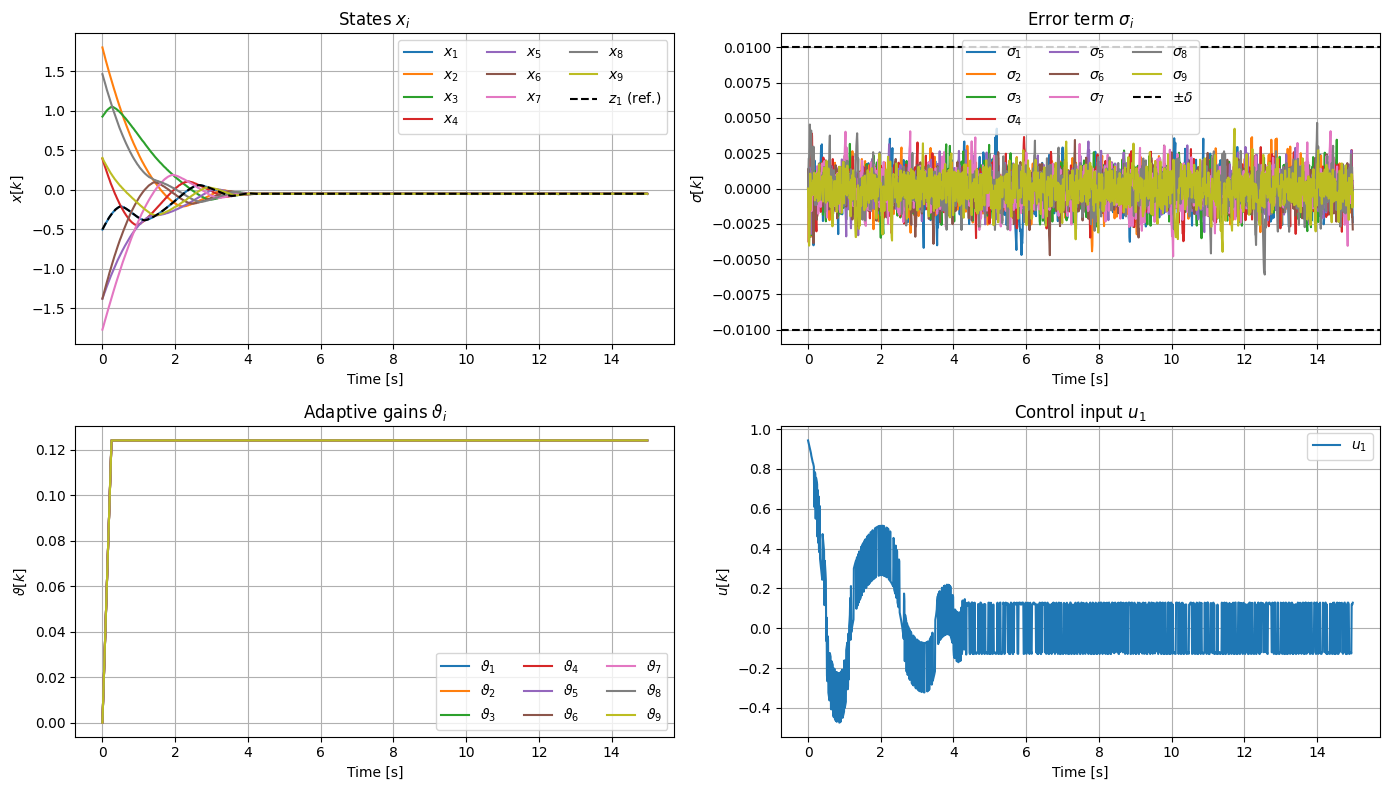

In [387]:
t_vec = np.linspace(0, dt*(n_points-1), n_points)
save_file = f'img/python-sim/simulation_{NUM_SIM}.pdf' if SAVE_FIGS else None
plot_simulation_grid(t_vec, x, z, vtheta, mv, n_agents, save_path=save_file)

---

### *Simulation Loop - 2*
**4th Order Runge-Kutta Method:** using $\verb|solve_ivp(.)|$ solver

In [388]:
if RUN_LOOP_SOLVE_IVP:
    print("\n--- Running simulation with solve_ivp ---\n")
    # Preallocate variables: states, manipulated variables and derivatives
    x = np.zeros(shape=(n_agents, n_points))
    z = np.zeros(shape=(n_agents, n_points))
    vtheta = np.zeros(shape=(n_agents, n_points))
    mv = np.zeros(shape=(n_agents, n_points))
    y = np.concatenate(
        [init_conditions["x"], init_conditions["z"], init_conditions["vtheta"]]
    )

    t = 0.0
    for k in range(n_points-1): 

        x[:, k] = y[:n_agents]
        z[:, k] = y[n_agents:2*n_agents]
        vtheta[:, k] = y[2*n_agents:3*n_agents]

        # Update for next iteration
        t_span = (t, t + dt)
        t_eval = (t, t + dt)
        sol = solve_ivp(
            dynamics, t_span, y, 
            t_eval=t_eval,
            args=(NODES, n_agents, nu[:, k], eta, mv, params)
        )
        y = sol.y[:, -1]  

        # Logging for agent 1
        if k % 50 == 0:
            print(f"Agent 1: t={t:.2f}, x1={x[0,k]:.4f}, z1={z[0,k]:.4f}, sigma1={(x[0,k] - z[0,k]):.8f}, vtheta1={vtheta[0,k]:.4f}, u1={mv[0,k]:.4f}")

        t += dt

In [389]:
if RUN_LOOP_SOLVE_IVP:
    t_vec = np.linspace(0, dt*(n_points-1), n_points)
    save_file = f'img/python-sim/simulation_ivp_{NUM_SIM}.pdf' if SAVE_FIGS else None
    plot_simulation_grid(t_vec, x, z, vtheta, mv, n_agents, save_path=save_file)

---

### *Simulation Loop - 3*

**Euler Integration Method**

In [390]:
# Preallocate variables: states, manipulated variables and derivatives
x = np.zeros(shape=(n_agents, n_points))
z = np.zeros(shape=(n_agents, n_points))
vtheta = np.zeros(shape=(n_agents, n_points))
sigma = np.zeros(shape=(n_agents, n_points))
v = np.zeros(shape=(n_agents,))

mv = np.zeros(shape=(n_agents, n_points))

y = np.concatenate(
    [init_conditions["x"], init_conditions["z"], init_conditions["vtheta"]]
)
x[:, 0] = y[:n_agents]
z[:, 0] = y[n_agents:2*n_agents]
vtheta[:, 0] = y[2*n_agents:3*n_agents]

t = 0.0
for k in range(n_points-1):

    # Reference dynamics
    for i in range(n_agents):
        neighbors = NODES[i]['neighbors']
        v[i] = g_i(i, z[:, k], neighbors)

    g = v
    z[:, k + 1] = z[:, k] + dt * g

    sigma[:, k] = x[:, k] - z[:, k]
    grad = np.sign(sigma[:, k])

    # Update adaptive gain theta with new eta parameter
    dtheta = np.zeros(n_agents)
    for i in range(n_agents):
        if np.abs(sigma[i, k]) > params["delta"]:
            if params["error_timer"]:
                small_error_timer[i] = 0  # reset timer
                dtheta[i] = eta * 1.0
            else:
                dtheta[i] = eta * 1.0
        else:
            if params["error_timer"]:
                small_error_timer[i] += 1
                if small_error_timer[i] < freeze_steps:
                    dtheta[i] = eta * 1.0  
                else:
                    dtheta[i] = 0.0  # freeze gain
            else:
                dtheta[i] = 0.0 # freeze gain

    vtheta[:, k + 1] = vtheta[:, k] + dt * dtheta
    # Control input
    u = g - vtheta[:, k] * grad
    mv[:, k] = u
    x[:, k + 1] = x[:, k] + dt * (u + nu[:, k])

    if k % 50 == 0:
        print(f"Agent 1: t={t:.2f}, x1={x[0,k]:.4f}, z1={z[0,k]:.4f}, sigma1={(x[0,k] - z[0,k]):.8f}, vtheta1={vtheta[0,k]:.4f}, u1={u[0]:.4f}")
    t += dt


Agent 1: t=0.00, x1=-0.5018, z1=-0.5018, sigma1=0.00000000, vtheta1=0.0000, u1=0.9468
Agent 1: t=0.50, x1=-0.2049, z1=-0.2066, sigma1=0.00165722, vtheta1=0.1250, u1=-0.0659
Agent 1: t=1.00, x1=-0.3550, z1=-0.3535, sigma1=-0.00149781, vtheta1=0.3750, u1=0.0806
Agent 1: t=1.50, x1=-0.3230, z1=-0.3172, sigma1=-0.00583014, vtheta1=0.5000, u1=0.7991
Agent 1: t=2.00, x1=-0.1371, z1=-0.1379, sigma1=0.00080689, vtheta1=0.5000, u1=-0.1055
Agent 1: t=2.50, x1=0.0372, z1=0.0389, sigma1=-0.00176320, vtheta1=0.5000, u1=0.7323
Agent 1: t=3.00, x1=0.0157, z1=0.0185, sigma1=-0.00280772, vtheta1=0.5000, u1=0.3166
Agent 1: t=3.50, x1=-0.0716, z1=-0.0744, sigma1=0.00278219, vtheta1=0.5000, u1=-0.6062
Agent 1: t=4.00, x1=-0.0494, z1=-0.0445, sigma1=-0.00494676, vtheta1=0.5000, u1=0.5658
Agent 1: t=4.50, x1=-0.0483, z1=-0.0502, sigma1=0.00192985, vtheta1=0.5000, u1=-0.5173
Agent 1: t=5.00, x1=-0.0509, z1=-0.0503, sigma1=-0.00063525, vtheta1=0.5000, u1=0.5104
Agent 1: t=5.50, x1=-0.0500, z1=-0.0506, sigma1=

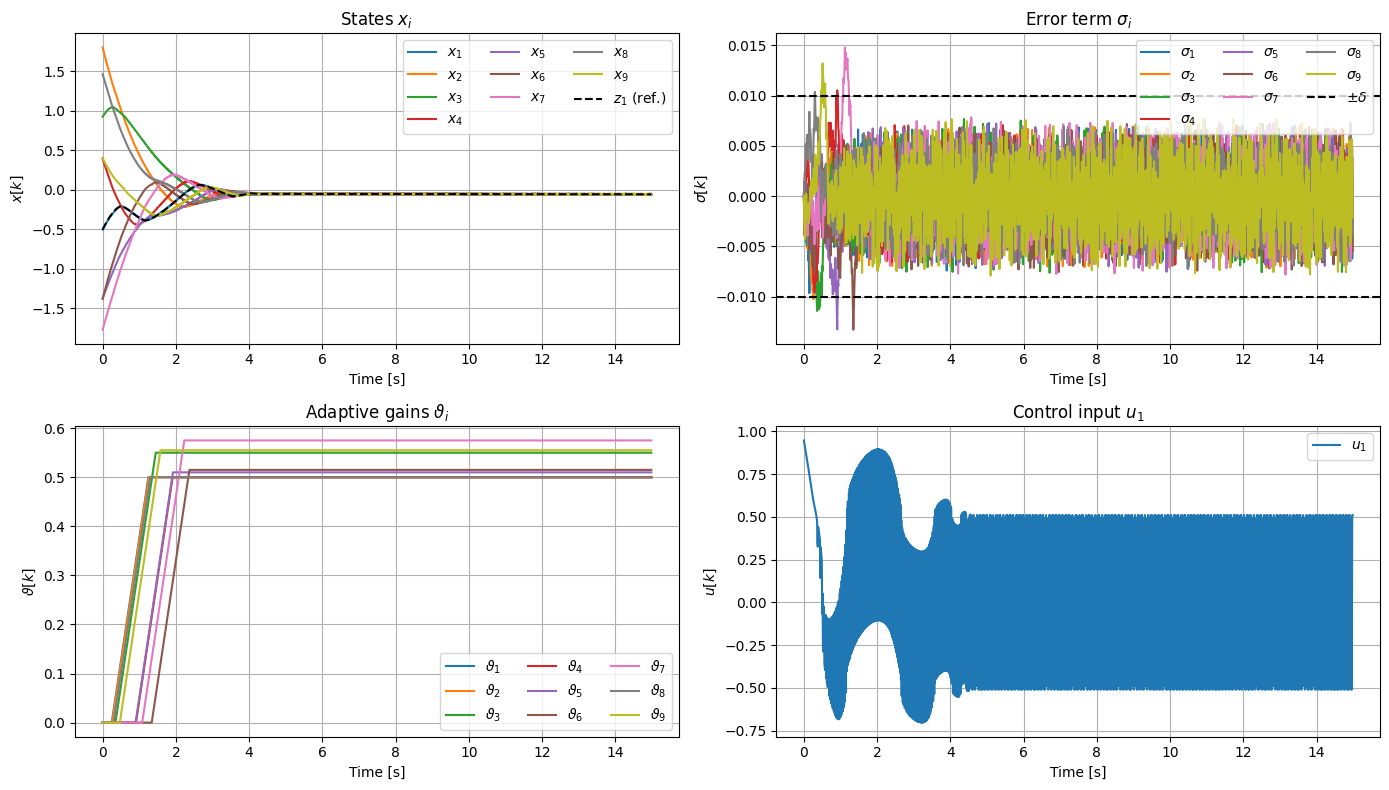

In [391]:
t_vec = np.linspace(0, dt*(n_points-1), n_points)
save_file = f'img/python-sim/simulation_euler_{NUM_SIM}.pdf' if SAVE_FIGS else None
plot_simulation_grid(t_vec, x, z, vtheta, mv, n_agents, save_path=save_file)

---

### *Simulation over a network transmission (Tx 32-bit integers)*

In [392]:
init_conditions_int32 = {
    "x": np.array([NODES[i]['x0_int32'] for i in range(n_agents)]),
    "z": np.array([NODES[i]['z0_int32'] for i in range(n_agents)]),
    "vtheta": np.zeros(n_agents, dtype=np.int32)  # Initial adaptive gains  
}

# Preallocate variables: states, manipulated variables and derivatives
x = np.zeros(shape=(n_agents, n_points), dtype=np.int32)
z = np.zeros(shape=(n_agents, n_points), dtype=np.int32)
vtheta = np.zeros(shape=(n_agents, n_points), dtype=np.int32)

sigma = np.zeros(shape=(n_agents, n_points), dtype=np.float32)
v = np.zeros(shape=(n_agents,), dtype=np.float32)

mv = np.zeros(shape=(n_agents, n_points), dtype=np.float32)

y = np.concatenate(
    [init_conditions_int32["x"], init_conditions_int32["z"], init_conditions_int32["vtheta"]]
)
x[:, 0] = y[:n_agents]
z[:, 0] = y[n_agents:2*n_agents]
vtheta[:, 0] = y[2*n_agents:3*n_agents]


t = 0.0
for k in range(len(time)-1):

    z_f = z[:, k] / scale_factor  
    x_f = x[:, k] / scale_factor
    vtheta_f = vtheta[:, k] / scale_factor

    # Reference dynamics
    for i in range(n_agents):
        neighbors = NODES[i]['neighbors']
        v[i] = g_i(i, z_f, neighbors)

    g = v
    z_f_next = z_f + dt * g

    sigma[:, k] = x_f - z_f

    grad = np.sign(sigma[:, k])

    # Update adaptive gain theta with new eta parameter
    dtheta = np.zeros(n_agents)
    for i in range(n_agents):
        if np.abs(sigma[i, k]) > params["delta"]:
            if params["error_timer"]:
                small_error_timer[i] = 0  # reset timer
                dtheta[i] = eta * 1.0
            else:
                dtheta[i] = eta * 1.0
        else:
            if params["error_timer"]:
                small_error_timer[i] += 1
                if small_error_timer[i] < freeze_steps:
                    dtheta[i] = eta * 1.0  
                else:
                    dtheta[i] = 0.0  # freeze gain
            else:
                dtheta[i] = 0.0 # freeze gain

    vtheta_f_next = vtheta_f + dt * dtheta
    # Control input
    u = g - vtheta_f * grad
    mv[:, k] = u
    
    x_f_next = x_f + dt * (u + nu[:, k])

    # Store as int32
    z[:, k + 1] = np.round(z_f_next * scale_factor).astype(np.int32)
    x[:, k + 1] = np.round(x_f_next * scale_factor).astype(np.int32)
    vtheta[:, k + 1] = np.round(vtheta_f_next * scale_factor).astype(np.int32)

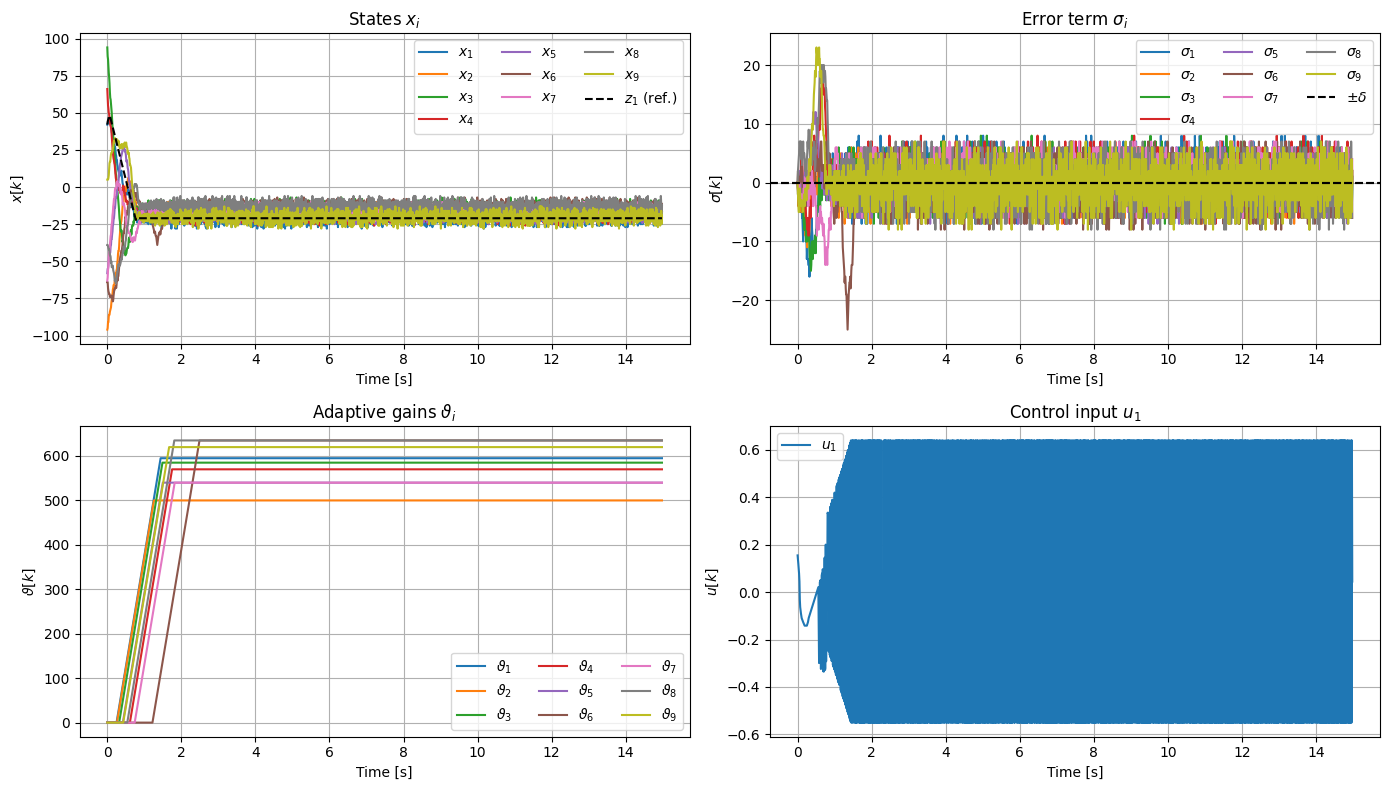

In [394]:
t_vec = np.linspace(0, dt*(n_points-1), n_points)
save_file = f'img/python-sim/simulation_int32_{NUM_SIM}.pdf' if SAVE_FIGS else None
plot_simulation_grid(t_vec, x, z, vtheta, mv, n_agents, save_path=save_file)